# CSSE John Hopkins University 

Utilities to import Covid-19 data from CSSE JHU source.

The DB structure is created with SQLAlchemy. Currently I have only tested it with SQLite3 but it should work fine with any of the supported engines (MySQL, Postgres, Oracle, SQL Server).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine

## Some minimal variables

In [3]:
data_dir='/Users/max4946/DEVEL/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
base_dir=os.getcwd()
db_name="covid"

## DB Structure

In [4]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Date
from sqlalchemy import ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.schema import UniqueConstraint
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine('sqlite:///{}/{}.sqlite3'.format(base_dir,
            db_name), echo=True) # Move this to your liking for different engine
Session = sessionmaker(bind=engine)

# import logging

# logging.basicConfig()
# logging.getLogger('sqlalchemy.engine').setLevel(logging.FATAL)

Base = declarative_base()

class City(Base):
    __tablename__ = 'city_table'

    id = Column(Integer, primary_key=True)
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=False)
    
    name = Column(String)
    short_name = Column(String)
  
    state = relationship("State")

    def __repr__(self):
        return "<City(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)


class State(Base):
    __tablename__ = 'state_table'

    id = Column(Integer, primary_key=True, nullable=False)
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)

    name = Column(String)
    short_name = Column(String)

    country = relationship("Country")
    
    def __repr__(self):
        return "<State(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)

    
class Country(Base):
    __tablename__ = 'country_table'

    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False, unique=True)
    short_name = Column(String)
    nickname = Column(String)
 
    
    def __repr__(self):
        return "<Country(name='%s', short_name='%s', nickname='%s')>" % (
                            self.name, self.short_name, self.nickname)

    
class DailyData(Base):
    __tablename__ = 'daily_data'
    __table_args__ = (
        UniqueConstraint("country_id", 
                      "state_id", "city_id", 
                      "date", name = "location_date_c" ),
    )
  
    id = Column(Integer, primary_key=True)
    
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)
    country = relationship("Country")
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=True)
    state = relationship("State")
    city_id = Column(Integer, ForeignKey('city_table.id'),
        nullable=True)
    city = relationship("City")
    
    date = Column(Date)
    confirmed = Column(Integer)
    recovered = Column(Integer)
    deaths = Column(Integer)

In [5]:
#engine

In [6]:
#Country.__table__, DailyData.__table__

## Create tables on the engine

In [7]:
Base.metadata.create_all(engine)

2020-04-19 14:25:01,348 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-04-19 14:25:01,349 INFO sqlalchemy.engine.base.Engine ()
2020-04-19 14:25:01,351 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-04-19 14:25:01,352 INFO sqlalchemy.engine.base.Engine ()
2020-04-19 14:25:01,353 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("city_table")
2020-04-19 14:25:01,354 INFO sqlalchemy.engine.base.Engine ()
2020-04-19 14:25:01,355 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("state_table")
2020-04-19 14:25:01,356 INFO sqlalchemy.engine.base.Engine ()
2020-04-19 14:25:01,357 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("country_table")
2020-04-19 14:25:01,357 INFO sqlalchemy.engine.base.Engine ()
2020-04-19 14:25:01,358 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("daily_data")
2020-04-19 14:25:01,359 INFO sqlalchemy.engine.base.Engine ()


## A *range()* function for dates

In [8]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

## Data importer *class*

In [9]:
import os.path
import csv

class csse_covid():
    """Read files from CSSE covid-19 daily report and put it 
    on a SQL database"""
    def __init__(self, data_dir):
        self.start_date = date(2020,4,14)
        self.end_date = date.today()
        self.data_dir = data_dir

    def run(self):
        self.read_files(self.start_date, self.end_date)
        
    def read_files(self, start_date, end_date):
        print(start_date, end_date)
        for d in daterange(start_date, end_date):
            print("Date: ", d)
            file = "{}/{}.csv".format(self.data_dir, 
                d.strftime("%m-%d-%Y"))
            if os.path.exists(file):
                data = pd.read_csv(file)
                data.fillna(0, inplace=True)
                self.to_sql(data, d)
            #break
    def to_sql(self, data, date):
        session = Session()
        data.columns = data.columns.str.replace('/',"_")
        data.columns = data.columns.str.replace(' ',"_")
        n_cols = len(data.columns)
        
        for r in data.itertuples():
            city = ""
            state = r.Province_State
            
            country = r.Country_Region
            confirmed = r.Confirmed
            recovered = r.Recovered
            deaths = r.Deaths

            if n_cols == 12:
                city = r.Admin2

            if state == "": # or np.isnan(state):
                state = country
                city = country
            # check/add Country
            country_q = session.query(Country).\
                filter(Country.name==country)
            if country_q.count() == 0:
                new_country = Country(name=country)
                session.add(new_country)
                session.commit()
                session.refresh(new_country)  
            elif country_q.count() == 1:
                new_country = country_q.first()
            # check/add State
            state_q = session.query(State).\
                filter(State.name==state).\
                filter(State.country_id==new_country.id)
            if state_q.count() == 0:
                new_state = State(name=state, country_id=new_country.id)
                session.add(new_state)
                session.commit()
                session.refresh(new_state)
            elif state_q.count() == 1:
                new_state = state_q.first()
            # check/add City
            city_q = session.query(City).\
                filter(City.name==city).\
                filter(City.state_id==new_state.id)
            if city_q.count() == 0:
                new_city = City(name=city, state_id=new_state.id)
                session.add(new_city)
                session.commit()
                session.refresh(new_city)
            elif city_q.count() == 1:
                new_city = city_q.first()
            
            daily_data = DailyData(date=date, country_id=new_country.id,
                    state_id=new_state.id, city_id=new_city.id, confirmed=confirmed,
                    recovered=recovered, deaths=deaths)
            try:
                session.add(daily_data)
                session.commit()
                session.refresh(daily_data)
                #print(daily_data)
            except:
                print("Error, likely a duplicated row: {}".format(daily_data))
                session.rollback()




## Running the importer

In [ ]:
Base.metadata.create_all(engine)
reader = csse_covid(data_dir)
reader.run()

## Very basic testing for the imported data

In [10]:
session = Session()
q = session.query(DailyData).join(Country).filter(Country.name== "Mexico")
mx = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
mx = mx[["confirmed","recovered","deaths"]].sort_index()
mx.sort_index()

2020-04-19 14:25:05,270 INFO sqlalchemy.engine.base.Engine SELECT daily_data.id, daily_data.country_id, daily_data.state_id, daily_data.city_id, daily_data.date, daily_data.confirmed, daily_data.recovered, daily_data.deaths 
FROM daily_data JOIN country_table ON country_table.id = daily_data.country_id 
WHERE country_table.name = ?
2020-04-19 14:25:05,271 INFO sqlalchemy.engine.base.Engine ('Mexico',)


,confirmed,recovered,deaths
date,,,
2020-01-23,0,0,0
2020-02-28,1,0,0
2020-02-29,4,0,0
2020-03-01,5,0,0
2020-03-02,5,0,0
2020-03-03,5,1,0
2020-03-04,5,1,0
2020-03-05,5,1,0
2020-03-06,6,1,0


In [ ]:
mx.plot()

In [71]:
6800/49000*100

13.877551020408163

# Playground (as usual)

In [ ]:
#session = Session()

In [ ]:
# test = Country(name='test', short_name='t', nickname='tt')
# session.add(test)
# session.commit()

In [ ]:
session = Session()
t = session.query(Country).filter(Country.name.like("t%"))
t.all()
#session.commit()

In [ ]:
print(t.statement, list(t.values()))

In [ ]:
# t.all()

In [ ]:
data = pd.read_csv("{}/01-23-2020.csv".format(data_dir))
data[data['Country/Region'] == 'Mexico']

In [59]:
from sqlalchemy import func
session = Session()

state = "San Antonio, TX"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')
                 ).join(State).filter(State.name== state).group_by(DailyData.date)
data = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
data = mx.sort_index()
data.tail()

2020-04-19 16:41:56,115 INFO sqlalchemy.engine.base.Engine SELECT daily_data.date, sum(daily_data.confirmed) AS confirmed, sum(daily_data.recovered) AS recovered, sum(daily_data.deaths) AS deaths 
FROM daily_data JOIN state_table ON state_table.id = daily_data.state_id 
WHERE state_table.name = ? GROUP BY daily_data.date
2020-04-19 16:41:56,115 INFO sqlalchemy.engine.base.Engine ('San Antonio, TX',)


,confirmed,recovered,deaths
date,,,
2020-04-14,5014,1964,332
2020-04-15,5399,2125,406
2020-04-16,5847,2125,449
2020-04-17,6297,2125,486
2020-04-18,6875,2125,546


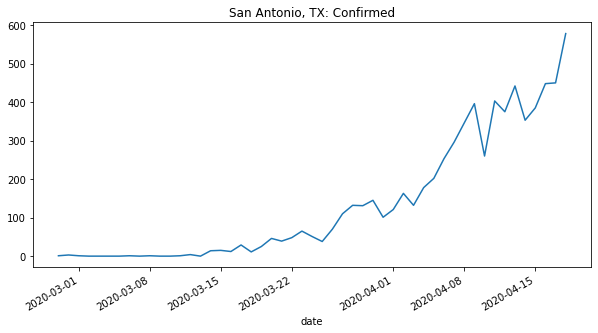

In [60]:
data["confirmed"].diff().plot(figsize=(10,5), title='{}: Confirmed'.format(state))

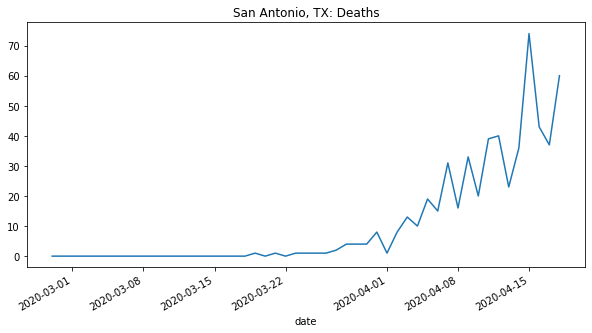

In [61]:
data["deaths"].diff().plot(figsize=(10,5), title='{}: Deaths'.format(state))

In [ ]:
641/22795*100

In [ ]:
9385/189033*100

In [ ]:
data = None
data, city

In [63]:
from sqlalchemy import func
session = Session()
data = None
city = "Bexar"
state = "Texas"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')).join(City).\
    filter(City.name==city).\
    group_by(DailyData.date)
data = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
data = data.sort_index()
data.tail(20)

2020-04-19 16:50:29,644 INFO sqlalchemy.engine.base.Engine SELECT daily_data.date, sum(daily_data.confirmed) AS confirmed, sum(daily_data.recovered) AS recovered, sum(daily_data.deaths) AS deaths 
FROM daily_data JOIN city_table ON city_table.id = daily_data.city_id 
WHERE city_table.name = ? GROUP BY daily_data.date
2020-04-19 16:50:29,645 INFO sqlalchemy.engine.base.Engine ('Bexar',)


,confirmed,recovered,deaths
date,,,
2020-03-30,157,0,6
2020-03-31,168,0,6
2020-04-01,207,0,9
2020-04-02,229,0,9
2020-04-03,254,0,9
2020-04-04,342,0,9
2020-04-05,384,0,11
2020-04-06,410,0,12
2020-04-07,456,0,12


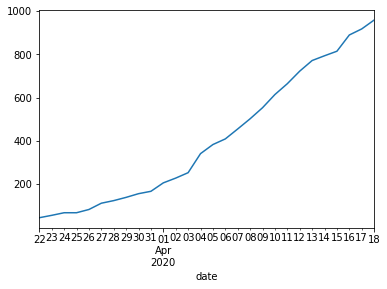

In [64]:
data["confirmed"].plot(logy=False)

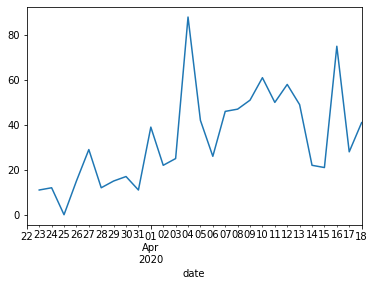

In [20]:
data["confirmed"].diff().plot(logy=False)

In [44]:
session = Session()
q = session.query(Country.name.label("Country"), Country.id,
                 func.count(State.id).label("states")
                 ).join(State).group_by(Country.id)
states = pd.read_sql(q.statement, q.session.bind)# , index_col='date', parse_dates="date")
#states = states[["confirmed","recovered","deaths"]].sort_index()
states.sort_values("states").tail(20)

2020-04-19 16:32:52,980 INFO sqlalchemy.engine.base.Engine SELECT country_table.name AS "Country", country_table.id, count(state_table.id) AS states 
FROM country_table JOIN state_table ON country_table.id = state_table.country_id GROUP BY country_table.id
2020-04-19 16:32:52,980 INFO sqlalchemy.engine.base.Engine ()


,Country,id,states
67,Ecuador,68,1
87,Liechtenstein,88,1
66,Qatar,67,1
74,Andorra,75,1
75,Latvia,76,1
35,Israel,36,2
36,Lebanon,37,2
22,Germany,23,2
42,Austria,43,2
32,Others,33,2


In [33]:
states.sort_values("states")

,name,states
117,Hong Kong SAR,1
149,Sudan,1
150,Guinea,1
151,Antigua and Barbuda,1
152,Aruba,1
...,...,...
133,United Kingdom,14
18,Canada,20
0,Mainland China,31
130,China,33


In [68]:
session = Session()
q = session.query(Country.name, State.name, State.id).join(State).\
    filter(Country.name == "South Korea")

states = pd.read_sql(q.statement, q.session.bind)
pd.set_option('display.max_rows', None)
states

2020-04-19 16:51:55,618 INFO sqlalchemy.engine.base.Engine SELECT country_table.name, state_table.name, state_table.id 
FROM country_table JOIN state_table ON country_table.id = state_table.country_id 
WHERE country_table.name = ?
2020-04-19 16:51:55,618 INFO sqlalchemy.engine.base.Engine ('South Korea',)


,name,name,id
0,South Korea,0,38
